In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
cols = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
df = pd.read_csv(url, names=cols)

In [3]:
df

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0    63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1    67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2    67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3    37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4    41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   
..    ...  ...  ...       ...    ...  ...      ...      ...    ...      ...   
298  45.0  1.0  1.0     110.0  264.0  0.0      0.0    132.0    0.0      1.2   
299  68.0  1.0  4.0     144.0  193.0  1.0      0.0    141.0    0.0      3.4   
300  57.0  1.0  4.0     130.0  131.0  0.0      0.0    115.0    1.0      1.2   
301  57.0  0.0  2.0     130.0  236.0  0.0      2.0    174.0    0.0      0.0   
302  38.0  1.0  3.0     138.0  175.0  0.0      0.0    173.0    0.0      0.0   

     slope   ca thal  target  
0      3.0  0.0  6.0       0  
1      2.0  3.0  3.0       2  
2      2.0  2.0  7.0       1  
3      3.0  0.0  3.0       0  
4      1.0  0.0  3.0       0  
..     ...  ...  ...     ...  
298    2.0  0.0  7.0       1  
299    2.0  2.0  7.0       2  
300    2.0  1.0  7.0       3  
301    2.0  1.0  3.0       1  
302    1.0    ?  3.0       0  

[303 rows x 14 columns]

In [4]:
df.replace('?', pd.NA, inplace=True)
df = df.dropna()
df = df.astype(float)

In [5]:
# Binary classification: 0 = no disease, 1 = disease
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

In [6]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:34:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [9]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4170eca5ecc81159f5c6f1298fcb6e3c47e28d2d4d9fd784af520e2a371ca93b
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


# **LIME**

In [10]:
import lime.lime_tabular
import numpy as np

In [11]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=X.columns,
    class_names=['No Disease', 'Disease'],
    mode='classification'
)
i = 5
exp = explainer.explain_instance(X_test_scaled[i], model.predict_proba)
exp.show_in_notebook()

In [12]:
for i in [0, 5, 10]:
    exp = explainer.explain_instance(X_test_scaled[i], model.predict_proba)
    exp.show_in_notebook()

Text(0.5, 0.98, 'LIME Explanation for Instance 10')

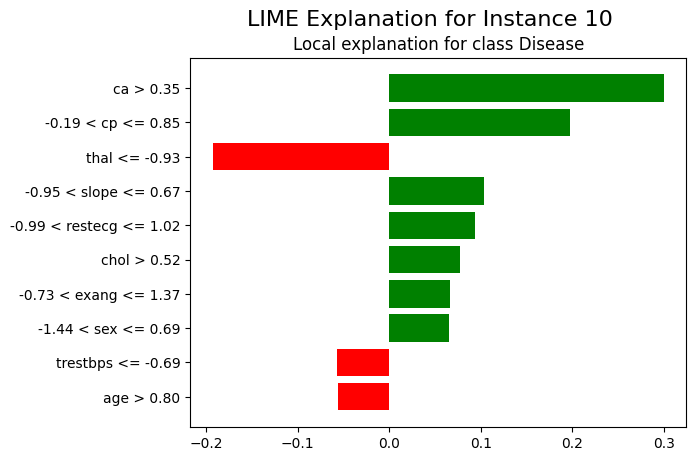

In [13]:
fig = exp.as_pyplot_figure()
fig.suptitle(f"LIME Explanation for Instance {i}", fontsize=16)

# **SHAP**

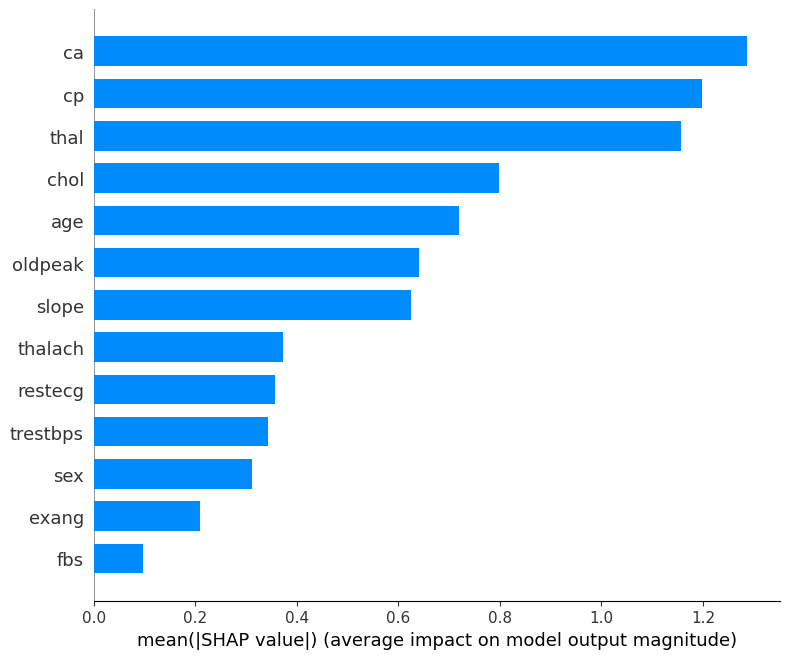

In [14]:
import shap

explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test, plot_type='bar')

shap.plots.force(shap_values[5])


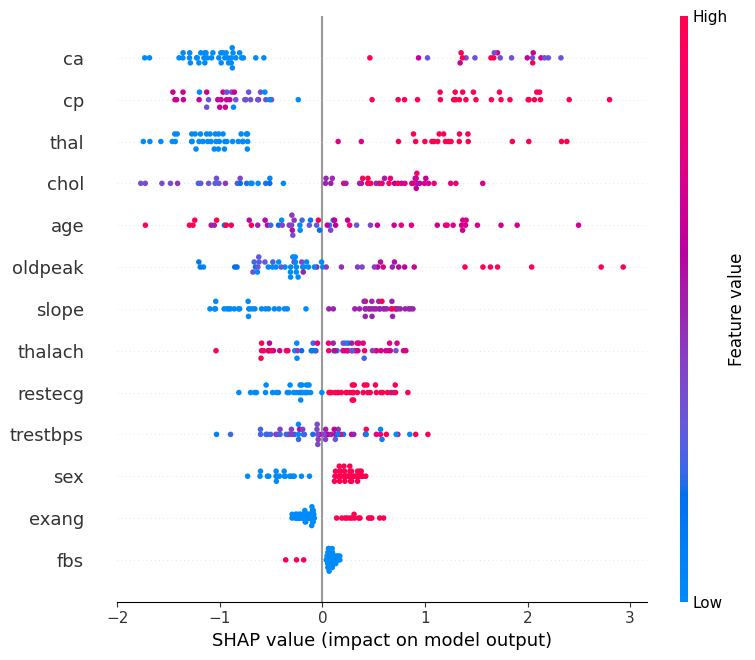

In [15]:
shap.summary_plot(shap_values, X_test, plot_type='dot')

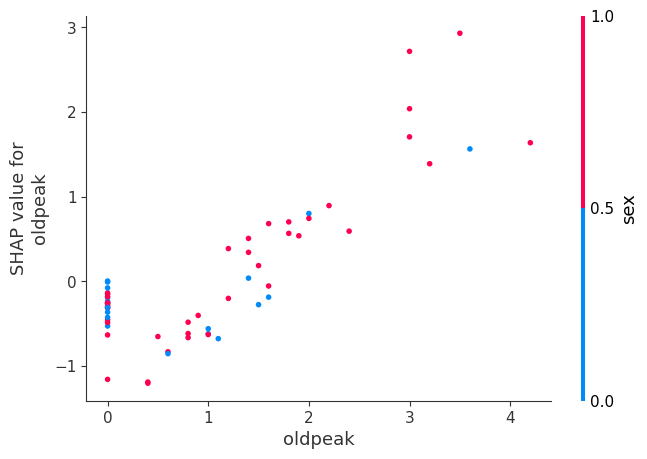

In [16]:
shap.dependence_plot("oldpeak", shap_values.values, X_test, interaction_index="sex")


In [17]:
import shap
shap.initjs()


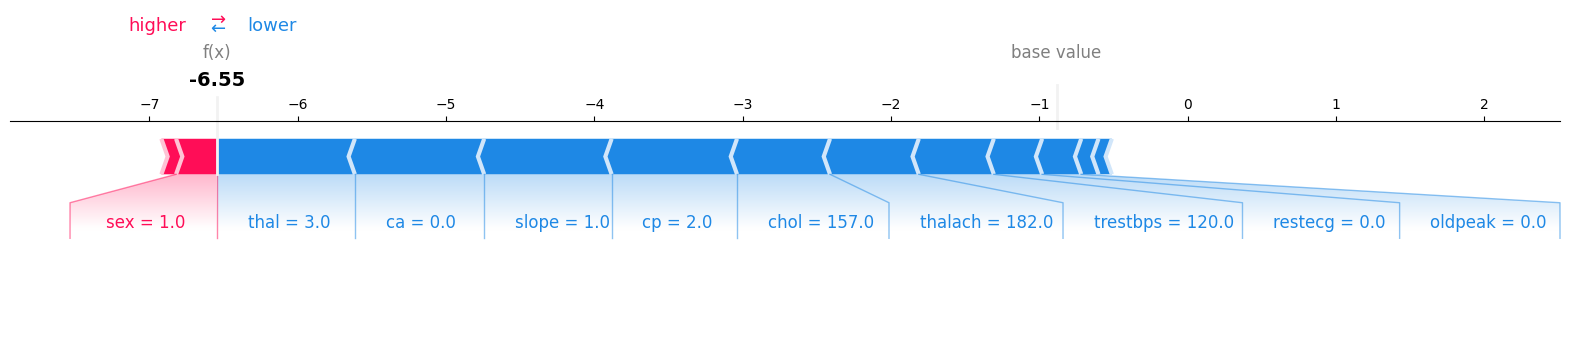

In [18]:
shap.force_plot(
    shap_values[0].base_values,
    shap_values[0].values,
    X_test.iloc[0],
    matplotlib=True
)


In [19]:
import shap

explainer = shap.Explainer(model, X_train_scaled, feature_names=X.columns)
shap_values = explainer(X_test_scaled)

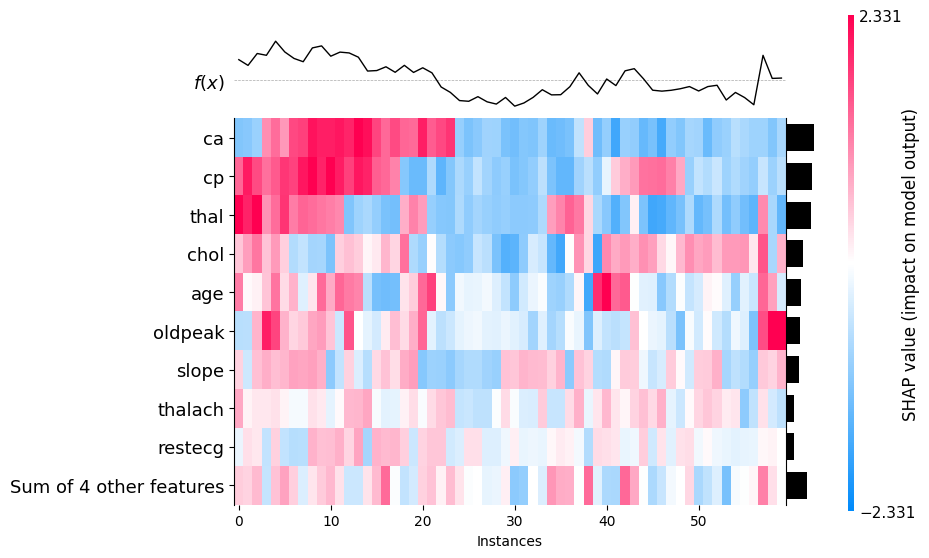

<Axes: xlabel='Instances'>

In [20]:
shap.plots.heatmap(shap_values)

# **PDP**

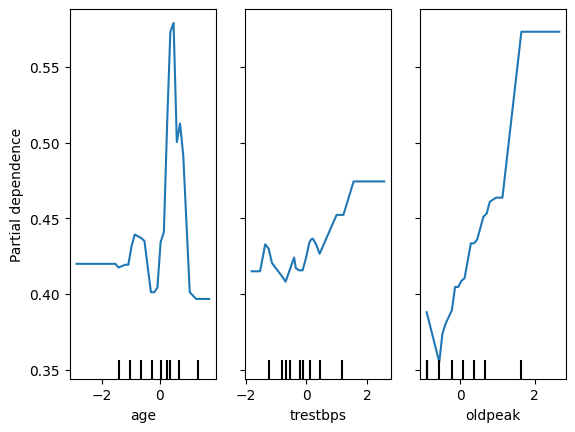

In [21]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    model, X_test_scaled, features=[0, 3, 9], feature_names=X.columns, kind="average"
)


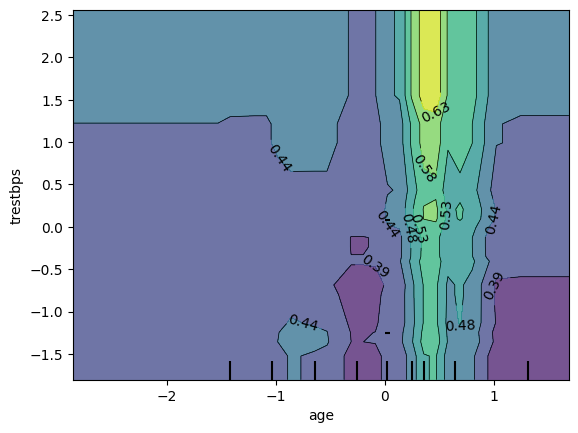

In [22]:
PartialDependenceDisplay.from_estimator(
    model, X_test_scaled, features=[(0, 3)], feature_names=X.columns
)
